# Youtube Data Analysis

## I. Project Description
To understand what people watch the most on Youtube in the US, I gathered video's data through [Youtube API v3](https://developers.google.com/youtube/v3/docs). The results returned by Search query via Youtube API contain approximately 200 records for each year from 2018 to 2022. Records are ordered by the number of views in descending order, telling us the most watched videos on Youtube. The dataset includes information below:
<ul>
    <li>Video Title</li>
    <li>Video ID</li>
    <li>Publish Date</li>
    <li>Channel Title</li>
    <li>Channel ID</li>
    <li>Video Category</li>
    <li>Video Duration</li>
    <li>Number of Views</li>
    <li>Number of Likes</li>
    <li>Number of Comments</li>
</ul>
Through this dataset, I will perform analyses to get a deeper understanding of:
<ol>
    <li>What are the most popular video categories?</li>
    <li>Does the viewer's preference change before and during Covid (considering we are still in Covid time)?</li>
    <li>What is viewer's preference for video's length?</li>
    <li>What are the best days in month to publish a video?</li>
    <li>Is there a linear relationship between number of views and likes/comments?</li>
</ol>

## II. Data Analysis
### Project Functions
To answer the major questions above, I will use below modules to support my analysis:
<ul>
    <li><b>numpy</b> and <b>pandas</b>: to handle data cleaning and calculation</li>
    <li><b>matplotlib</b> and <b>seaborn</b>: to graph data</li>
    <li><b>isodate</b>: to handle conversion of video duration to seconds</li>
    <li><b>sklearn</b>: to run linear regression</li>
</ul>

In [1]:
pip install isodate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import isodate
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None

In [3]:
def duration_convert(duration):
    dur = isodate.parse_duration(duration)
    return dur.total_seconds()

### Loading Video Data
There are two files I exported as a result of requesting to Youtube API: `Video_Categories.csv` and `Youtube_video_data.csv`.

In [4]:
df = pd.read_csv("Youtube_video_data.csv")
df_cat = pd.read_csv("Video_Categories.csv")

In [5]:
df.head(3)

,vid_title,vid_id,publish_date,channel_title,channel_id,category_id,duration,views,likes,comments
0,NASA Live: Official Stream of NASA TV,21X5lGlDOfg,2018-12-28T18:40:15Z,NASA,UCLA_DiR1FfKNvjuUpBHmylQ,28,P0D,136274799,2094730,0
1,Pocoyó - Porquera en la tubería (S04E05),DTyy5Hf46Fs,2018-06-17T11:41:25Z,Pocoyo Series,UCzKG_Nq4SAWE-VBEuHo3jYA,1,PT7M9S,118073485,504562,0
2,Rap Live Radio 24/7 | Hip-Hop & Popular Rap Mu...,05689ErDUdM,2018-11-30T21:26:38Z,UPROXX Music,UCI2HI_aQ_S3v4vfDQgNtK1g,10,P0D,28581927,337831,7


In [6]:
df_cat.head(3)

,category_id,category_name
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music


### Cleaning Data
#### 1. The dataset contains some duplicates and we will need to remove them from our data before analyzing. 

In [7]:
df = df.drop_duplicates('vid_id')

#### 2. The data format of `duration` and `publish_date` is inappropriate for our analysis. We will need to:
<ul>
    <li>convert duration to seconds</li>
    <li>extract year, month, day from publish_date</li>
</ul>

##### 2.1 Let's convert `duration` to seconds first:

In [8]:
for i in range(len(df)):
    df['duration'].iloc[i] = duration_convert(df['duration'].astype(str).iloc[i])

If a video is live, its duration will be 0. Let's check if we have any of them in our dataset:

In [9]:
0 in df['duration']

True

Identifying live videos is necessary for our analysis of video's length, as we don't want to average 0-duration videos with others. Let's add a new column `live_status` to our data frame:

In [10]:
df['live_status'] = None
for i in range(len(df)):
    if df['duration'].iloc[i] == 0:
        df['live_status'].iloc[i] = 'Yes'
    else:
        df['live_status'].iloc[i] = 'No'

##### 2.2 Now, extract year, month, and day from `publish_date`. I will add new columns to the data frame as below:

In [11]:
df['publish_date'] = pd.to_datetime(df['publish_date'])
df['publish_year'] = df['publish_date'].dt.year
df['publish_month'] = df['publish_date'].dt.month
df['publish_day'] = df['publish_date'].dt.day

#### 3. We have Category IDs in `df` data frame but their respective names are in another data frame, `df_cat`. We will need to map them up:

In [12]:
df['category_name'] = None
for i in range(len(df)):
    cat_id = df['category_id'].iloc[i]
    for index in range(len(df_cat)):
        if cat_id == df_cat['category_id'].iloc[index]:         
            df['category_name'].iloc[i] = df_cat['category_name'].iloc[index]

### Data Analysis

#### Question 1: What are the most popular video categories?
##### First Approach:
Since our dataset contains the most watched videos list, if a category presents more often than another in our list, it implies that category is more popular. Let's count how many times each category presents in our list (2018-2022):

In [13]:
pop_cat = df.groupby('category_name')['vid_id'].count()
pop_cat = pop_cat.to_frame().reset_index()
pop_cat = pop_cat.set_index('category_name')
pop_cat = pop_cat.rename(columns={'vid_id':'number_of_videos'})
pop_cat.sort_values(by = 'number_of_videos',ascending = False).head(5)

,number_of_videos
category_name,
Shows,189
Gaming,161
Entertainment,97
News & Politics,92
Music,82


Top 5 most popular categories over the past 5 years are:
<ol>
    <li>Shows</li>
    <li>Gaming</li>
    <li>Entertainment</li>
    <li>News & Politics</li>
    <li>Music</li>
</ol>

##### Second Approach:
But there is an issue with the 1st approach. A higher number of videos doesn't mean that category has a higher views than another. And number of views is also an indicator of popularity. But we can't rely on total views per category to evaluate because our list is limited and not a full list. Therefore, given the limit of our dataset, a more accurate approach is to take into account both indicators: <b><i>views</i></b> and <b><i>number of videos</i></b>. <b>Average views per video</b> can be a more accurate indicator as it reflects both views and number of videos.

However, a part of our dataset doesn't have information about views, as those videos are marked private and available to only paid users. Let's temporarily exclude those private videos to calculate <b>Average views per video</b>. 

In [14]:
df_1 = df[df['views'] != 'Private']

Calculate views (millions) grouped by video categories:

In [15]:
df_1['views'] = df_1['views'].astype(int)/1000000
views_by_cat = df_1.groupby('category_name')['views'].sum()
views_by_cat = views_by_cat.to_frame().reset_index()
views_by_cat = views_by_cat.set_index('category_name')

Calculate number of videos by category after excluding private videos:

In [16]:
pop_cat_1 = df_1.groupby('category_name')['vid_id'].count()
pop_cat_1 = pop_cat_1.to_frame().reset_index()
pop_cat_1 = pop_cat_1.set_index('category_name')
pop_cat_1 = pop_cat_1.rename(columns={'vid_id':'number_of_videos'})

Calculate views per video, grouped by video categories:

In [17]:
views_per_vid = views_by_cat['views'].div(pop_cat_1['number_of_videos'])
views_per_vid = views_per_vid.to_frame().reset_index()
views_per_vid = views_per_vid.rename(columns={0:'average_views_per_vid'})
views_per_vid = views_per_vid.sort_values('average_views_per_vid', ascending = False)

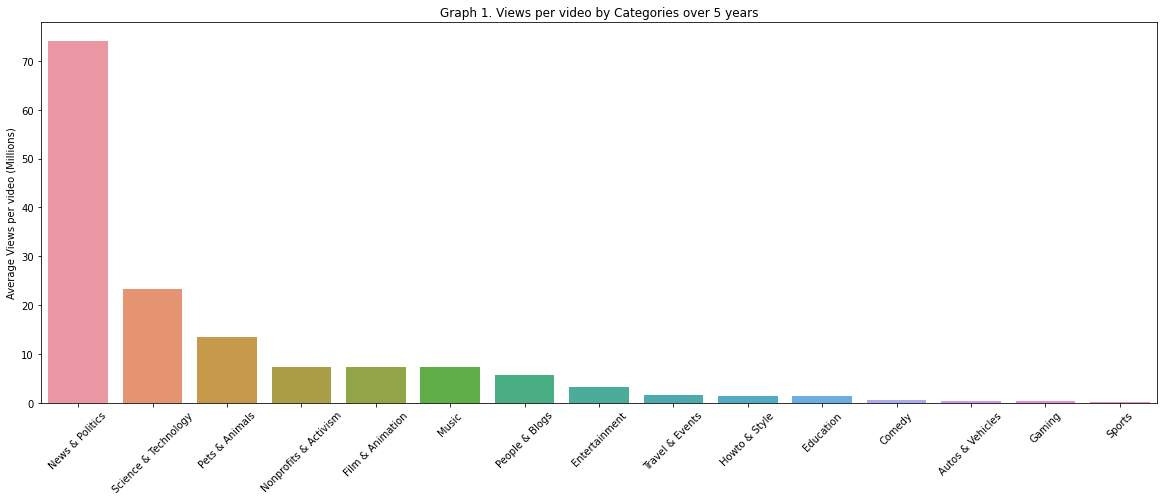

In [18]:
plt.figure(figsize =(20, 7))
plt.xticks(rotation=45)
ax = sns.barplot(x='category_name', y='average_views_per_vid', data=views_per_vid)
ax.set(xlabel=None)
ax.set_ylabel("Average Views per video (Millions)");
ax.set_title("Graph 1. Views per video by Categories over 5 years");

This graph shows that Top 5 categories which have the most views per video are:
<ol>
    <li>News & Politics</li>
    <li>Science & Technology</li>
    <li>Pets & Animals</li>
    <li>Nonprofits & Activism</li>
    <li>Film & Animation</li>
</ol>

Only `News & Politics` remains in the Top 5. `Music` falls to rank 6th but has quite close views to `Film & Animation`, which is ranked 5. Meanwhile, `Gaming`, and `Entertainment` rank much lower than in the 1st approach, and `Shows` even is out of the list. The cause of this drastic change may be that we excluded private videos which belong to those categories. Let's check the gaps before and after excluding private videos:

In [19]:
pop_cat_diff = pop_cat.subtract(pop_cat_1, fill_value = 0)
pop_cat_diff = pop_cat_diff.rename(columns={'number_of_videos':'no_vid_diff'})
pop_cat_diff[pop_cat_diff['no_vid_diff'] != 0].sort_values('no_vid_diff', ascending = False)

,no_vid_diff
category_name,
Shows,189.0
Movies,39.0
Entertainment,1.0
Music,1.0


Clearly, we excluded all `Shows` videos in our calculation, and that's why this category falls to the lowest rank. However, we are still unsure if we can trust the graph 1. Let's dive deeper into each year performance. 

###### How did top 3 change year over year? 
Let's count the number of videos of each category per year, excluding private videos:

In [20]:
cat_yoy = df_1.groupby(['publish_year','category_name'])['vid_id'].count()
cat_yoy = cat_yoy.to_frame().reset_index()
cat_yoy = cat_yoy.rename(columns={'vid_id':'number_of_videos'})

Now, calculate total views per category per year:

In [21]:
cat_views_yoy = df_1.groupby(['publish_year','category_name'])['views'].sum()
cat_views_yoy = cat_views_yoy.to_frame().reset_index()

Finally, average views per video by category by year:

In [22]:
cat_views_yoy['avg_views_per_vid'] = cat_views_yoy['views']/cat_yoy['number_of_videos']
cat_views_yoy = cat_views_yoy.sort_values(
    ['publish_year', 'avg_views_per_vid'], ascending=[True, False]).groupby('publish_year').head(3)

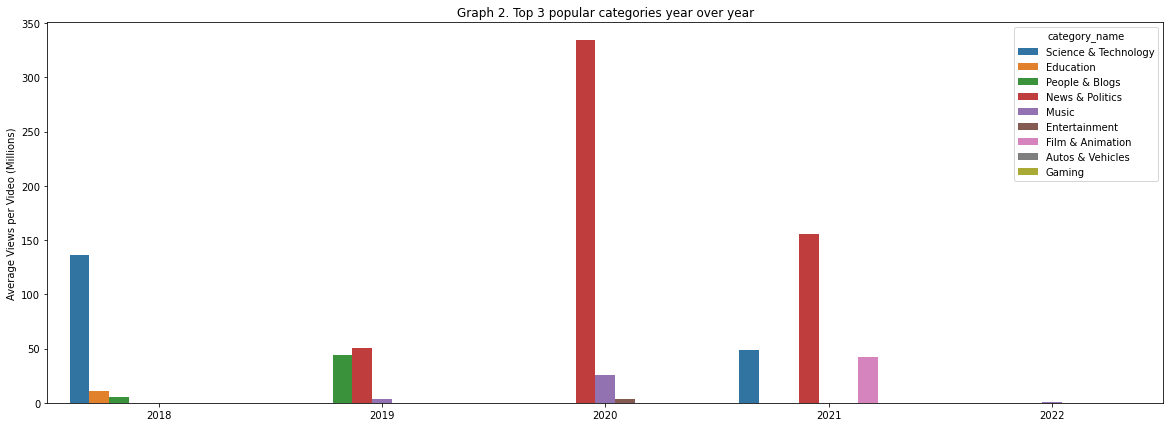

In [23]:
plt.figure(figsize =(20, 7))
ax = sns.barplot(x='publish_year', y='avg_views_per_vid', data=cat_views_yoy, hue='category_name')
ax.set(xlabel=None)
ax.set_ylabel("Average Views per Video (Millions)");
ax.set_title("Graph 2. Top 3 popular categories year over year");

It's interesting that in graph 1, `Pets & Animals` is in the Top 3 over the past 5 years, but graph 2 tells us a different story: <b><i>it doesn't appear in Top 3 for any of the 5 years</i></b>. That means we have a significant issue with the 2nd approach: the way we calculated <b>Average views per video</b> doesn't consider the low presentation of a category in a given year. For example, we have no record of `Pets & Animals` for 2018-2020 and 2022. The average views per video for this category was calculated based on only records for 2021. Thus, it's obvious that we can't conclude `Pets & Animals` a popular category over a 5-year period.

In [24]:
pet_records = cat_yoy[cat_yoy['category_name'] == 'Pets & Animals']
pet_records

,publish_year,category_name,number_of_videos
45,2021,Pets & Animals,3


##### Third Approach:

To eliminate the above issue, we will calculate <b>Relative views per category</b> by taking into account the proportion of each category in the whole dataset. For example, if `Gaming` and `Music` had 100M views each but `Gaming` contributed 20% of the dataset while `Music` accounted for only 5%, the relavtive views of `Gaming` would be 100M * 20% = 20M views while that of `Music` would be only 5M views. And in this case, `Gaming` is more popular than `Music`.

Now, let's calculate the proportion of each category in our dataset:

In [25]:
ttl_vid = pop_cat_1.sum()
weighted_cat = pop_cat_1/ttl_vid 
weighted_cat = weighted_cat.rename(columns={'number_of_videos':'weight'})

Calculate relative views per category:

In [26]:
weighted_cat['relative_views'] = weighted_cat['weight'] * views_by_cat['views']
weighted_cat = weighted_cat.reset_index()
weighted_cat = weighted_cat.sort_values('relative_views', ascending = False)

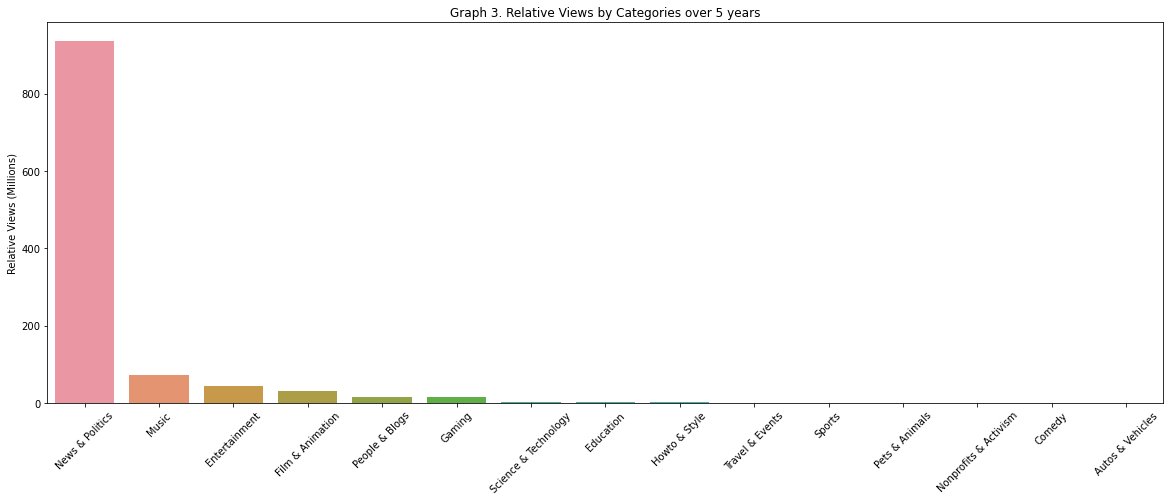

In [27]:
plt.figure(figsize =(20, 7))
plt.xticks(rotation=45)
ax = sns.barplot(x='category_name', y='relative_views', data=weighted_cat)
ax.set(xlabel=None)
ax.set_ylabel("Relative Views (Millions)");
ax.set_title("Graph 3. Relative Views by Categories over 5 years");

Graph 3 tells us that the Top 5 over the last 5 years are:
<ol>
    <li>News & Politics</li>
    <li>Music</li>
    <li>Entertainment</li>
    <li>Film & Animation</li>
    <li>People & Blogs</li>
</ol>

`Gaming` has relative views quite close to `People & Blogs`. We can say they two are on and off the Top 5. 

#### Question 2: Does the viewer's preference change before and during Covid (considering we are still in Covid time)?
From question 1, we will look deeper into how relative views by categories change year over year. Let's calculate the proportion of each category in our dataset:

In [28]:
ttl_vid_yoy = cat_yoy.groupby('publish_year')['number_of_videos'].sum()
ttl_vid_yoy = ttl_vid_yoy.to_frame().reset_index()

In [29]:
cat_yoy['weight'] = None
for i in range(len(cat_yoy)):
    cat_year = cat_yoy['publish_year'].iloc[i]
    for index in range(len(ttl_vid_yoy)):
        if cat_year == ttl_vid_yoy['publish_year'].iloc[index]:
            cat_yoy['weight'].iloc[i] = cat_yoy['number_of_videos'].iloc[i]/ttl_vid_yoy['number_of_videos'].iloc[index]

Calculate relative views per category:

In [30]:
cat_yoy['relative_views'] = cat_yoy['weight'] * cat_views_yoy['views']
cat_yoy = cat_yoy.sort_values(['publish_year', 'relative_views'], ascending=[True, False]).groupby('publish_year').head(3)
cat_yoy

,publish_year,category_name,number_of_videos,weight,relative_views
9,2018,Science & Technology,1,0.00641,0.873556
1,2018,Education,3,0.019231,0.616267
8,2018,People & Blogs,4,0.025641,0.575914
17,2019,News & Politics,17,0.130769,112.154509
16,2019,Music,24,0.184615,17.320723
19,2019,People & Blogs,4,0.030769,5.419694
30,2020,News & Politics,9,0.09375,281.769613
29,2020,Music,10,0.104167,26.779784
25,2020,Entertainment,6,0.0625,1.28362
42,2021,News & Politics,19,0.128378,379.635365


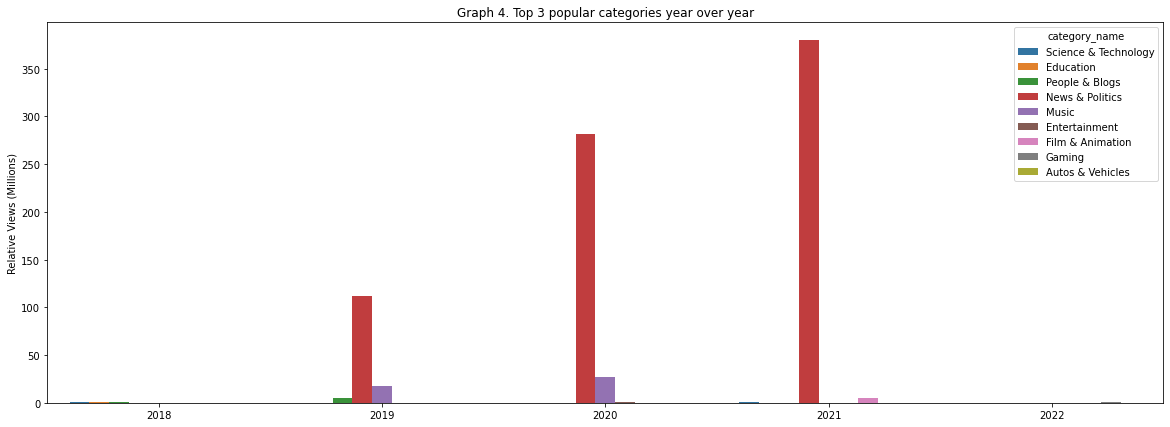

In [31]:
plt.figure(figsize =(20, 7))
ax = sns.barplot(x='publish_year', y='relative_views', data=cat_yoy, hue='category_name')
ax.set(xlabel=None)
ax.set_ylabel("Relative Views (Millions)");
ax.set_title("Graph 4. Top 3 popular categories year over year");

From graph 4 and `cat_yoy` table, we can see that:
<ul>
    <li><b><i>News & Politics</i></b> became more prevalent during Covid</li> 
    <li><b><i>Music</i></b> usually stays in the Top 3</li> 
    <li><b><i>People & Blogs</i></b> was in the Top 3 before Covid only</li> 
    <li>The relative number of views in 2022 is significantly lower than the previous years. It may be because of the rise of other media platforms after the Covid hit. People gradually got used to the different platforms and relied less on Youtube, especially when Youtube pushed more ads to free users.</li>

#### Question 3: What is viewer's preference for video's length?
To answer it, we will analyze videos that have a significant number of views, say, at least 1M views. Remember that there are live videos which have 0 duration and we need to exclude them from our calculation. Let's calculate the average duration per video:

In [32]:
df_1M = df_1[(df_1['views'] >= 1) & (df_1['live_status'] == 'No')]
vid_1M_dur = round(df_1M.groupby('category_name')['duration'].mean()/60, 1) #convert duration from seconds to minutes
vid_1M_dur = vid_1M_dur.to_frame().reset_index().sort_values('duration')

We can classify short videos are one less than 10-min duration, medium videos are from 10-min to 15-min duration, and long videos are over 15 mins:

In [33]:
vid_1M_dur['length'] = None
for i in range(len(vid_1M_dur)):
    if vid_1M_dur['duration'].iloc[i] < 10:
        vid_1M_dur['length'].iloc[i] = 'short'
    elif 10 <= vid_1M_dur['duration'].iloc[i] <= 15:
        vid_1M_dur['length'].iloc[i] = 'medium'
    else:
        vid_1M_dur['length'].iloc[i] = 'long'

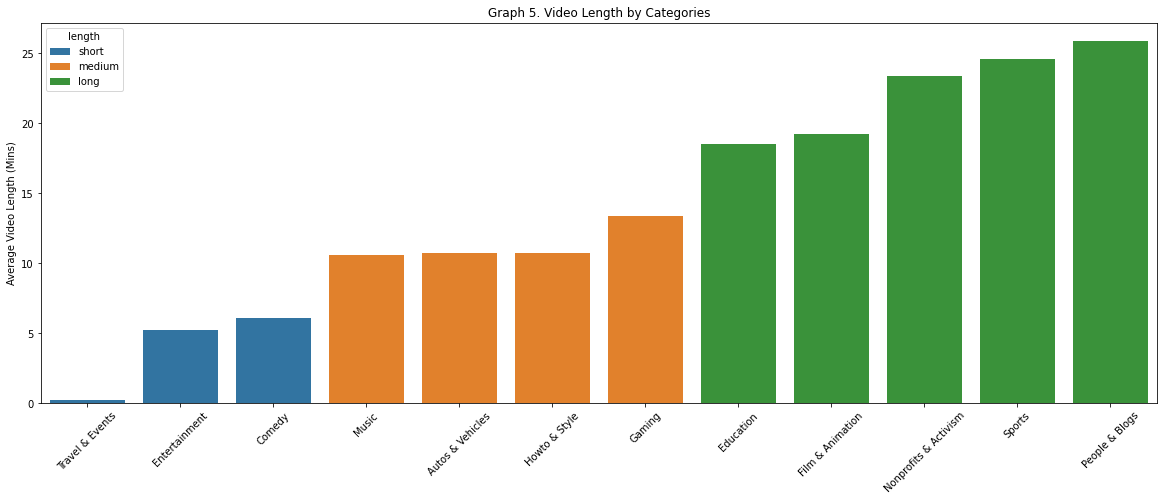

In [34]:
plt.figure(figsize =(20, 7))
plt.xticks(rotation=45)
ax = sns.barplot(x='category_name', y='duration', data=vid_1M_dur, hue='length', dodge = False)
ax.set(xlabel=None)
ax.set_ylabel("Average Video Length (Mins)");
ax.set_title("Graph 5. Video Length by Categories");

From graph 5, we can see that viewers have different preference for video's length, depending on the type/category of the video.

#### Question 4: What are the best days in month to publish a video?

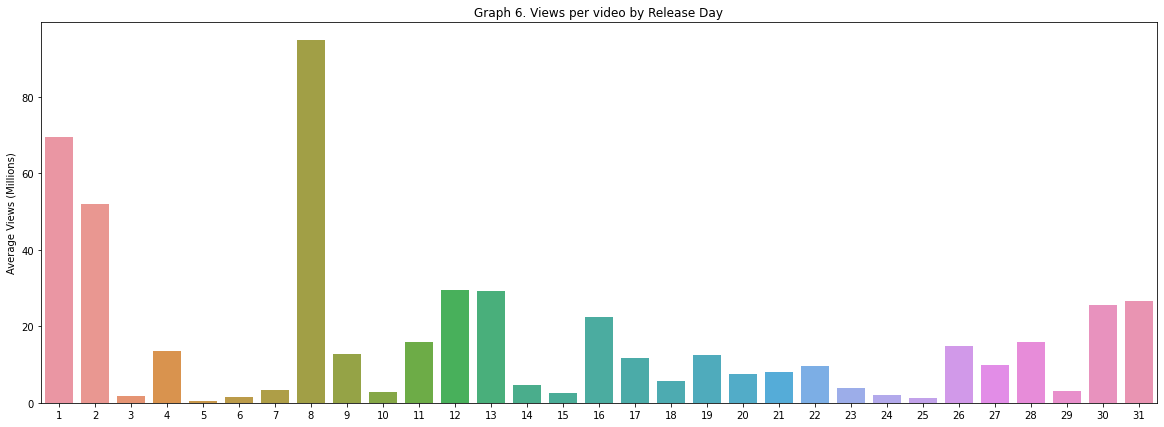

In [35]:
plt.figure(figsize =(20, 7))
ax = sns.barplot(x='publish_day', y='views', data=df_1, ci = None)
ax.set(xlabel=None)
ax.set_ylabel("Average Views (Millions)");
ax.set_title("Graph 6. Views per video by Release Day");

Graph 6 tells us that videos published on day <b>1st</b>, <b>2nd</b>, and <b>8th</b> of a month received the most views.

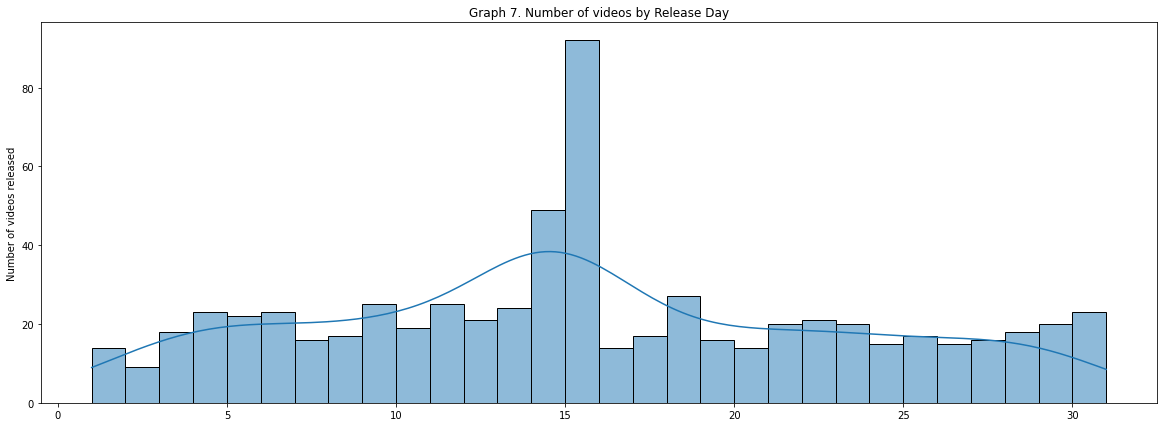

In [36]:
plt.figure(figsize =(20, 7))
ax = sns.histplot(data=df_1, x='publish_day', binwidth=1, kde=True)
ax.set(xlabel=None)
ax.set_ylabel("Number of videos released");
ax.set_title("Graph 7. Number of videos by Release Day");

Graph 7 tells an interesting story: <b><i>most videos were published around day 15th of a month</i></b>, but top-watched videos were on published ealier in the month.

#### Question 5: Is there a linear relationship between number of views and likes/comments?

In our dataset, some videos have the like and/or comment function disabled yet have high view volume. For those videos, clearly, there is no linear relationship between views and likes/comments.

Let's examine videos which allow viewers to like and/or comment. 
##### First, let's work with videos having like function enabled.

In [37]:
df_like = df_1[df_1['likes'] != 'Disabled']

Now, run linear regression on this data set:

In [38]:
predictors = ['likes']
X = np.array(df_like[predictors])
y = np.array(df_like['views'])
model = LinearRegression().fit(X, y)

print(f'The model is Views = {model.coef_[0]:.3} * (likes) + {model.intercept_:.3}')
print(f'R^2 is {model.score(X, y):.3}')

The model is Views = 0.000328 * (likes) + -0.566
R^2 is 0.414


There is a <b><i>weak linear relationship between the number of likes and views</i></b>, as this model can explain only about 40% of observations. In reality, a video with many dislikes can also receive high views. Therefore, I'm skeptical about the relationship between the number of views and dislikes. But, since Youtube doesn't give the number of dislikes, I can't verify my hypothesis. 

##### Second, let's work with videos having comment function enabled.

In [39]:
df_cmt = df_1[df_1['comments'] != 'Disabled']

Now, run linear regression on this data set:

In [40]:
predictors = ['comments']
X = np.array(df_cmt[predictors])
y = np.array(df_cmt['views'])
model = LinearRegression().fit(X, y)

print(f'The model is Views = {model.coef_[0]:.3} * (comments) + {model.intercept_:.3}')
print(f'R^2 is {model.score(X, y):.3}')

The model is Views = 0.00109 * (comments) + 10.7
R^2 is 0.000412


This model tells us that <b><i>comments and views don't have a linear relationship</i></b>, as this model can't explain even only 1% of our records.